## Calculate overlapping T and pH extremes obs and model- make figs for paper

In [1]:
%%time
import numpy as np
from matplotlib import colormaps as mplcm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import pandas as pd
from Tools import commonfxns as cf, OAPBuoyData as OAP, mplRC, OAPBuoyComp as bc,viz, evalfxns as ev, frequencyBands as fb
import netCDF4 as nc
import cftime
import datetime as dt
import cmocean
#import gsw
#from sklearn.linear_model import TheilSenRegressor
import pickle
import os
#from IPython.display import Markdown, display, HTML
#import astropy.timeseries as apt
from collections import OrderedDict
import warnings
from matplotlib.colors import ListedColormap
import xarray as xr
from scipy import stats

pd.set_option('display.max_rows', None)
mplRC.paperRC2();

CPU times: user 1.88 s, sys: 1.53 s, total: 3.41 s
Wall time: 3.41 s


In [2]:
import matplotlib.ticker as mtick
mtick.AutoLocator.__init__ = lambda self: mtick.MaxNLocator.__init__(self,nbins='auto',steps=[1,2,2.5,3,4,5,10])

In [3]:
3.4*365,3.48*365,1300/365.25

(1241.0, 1270.2, 3.5592060232717317)

In [4]:
minyears=3.4#8# changed to 3 to include a coral site 4 # number of years of observation data required

## first, identify the stations with the most combined T and estimated pH data

In [5]:
dfInfoBuoy=OAP.loadOAPInfo(modelgrid=True,modMeans=True)
compsdir='/work/ebo/calcs/buoyCompTS/presentday/comps/'

In [6]:
dsid=OAP.getID('Parguera')

In [7]:
cpath='/work/ebo/calcs/buoyCompTS/presentday/comps/'
omcomp=bc.loadMoorComp(dsid,'omega_a_P_0',freq='daily',path=cpath)

In [8]:
len(omcomp.obs_val)/365.25

3.485284052019165

In [9]:
cpath='/work/ebo/calcs/buoyCompTS/presentday/comps/'
tcomp=bc.loadMoorComp(dsid,'tos',freq='daily',path=cpath)
phCcomp=bc.loadMoorComp(dsid,'phosC',freq='daily',path=cpath)

In [10]:
omcomp=bc.loadMoorComp(dsid,'omega_a_0',freq='daily',path=cpath)

In [11]:
omcomp

Tools.evalfxns.timeSeriesComp(
	 modvar=omega_a_0, stationID=pmel_co2_moorings_ab03_dbac_935b, staname=La Parguera NOAA Surface Ocean CO2 and Ocean Acidification Mooring Time Series, freq=daily
	 other instance variables:version,shortTitle,shortID,lat,lon,savepath,figsavepath,compsavepath,tref,yrfaco,yrfacm,mlen,obs_tdt,obs_val,dispName,dispUnits,dispNameUnits,obsvar,mod_tnl,mod_tdt,mod_val,obs_yd,obs_ym,iiOLo,mod_yd,mod_ym,mod_yind,obs_yind,fityrlen,iiOLm,obs_trange,mod_trange,OL_trange,trange,defaultfit,modfits,obsfits,mod_targetdind,obs_targetdind,target_datetime,mod_target,obs_target,obs_target_b,mod_targetdeseas,obs_targetdeseas,obs_targetdeseas_b,mod_gsmooth,obs_gsmooth,obs_gsmooth_b,stats,mod_tind,obs_tind,obs_tind_b,mod_intt,obs_intt)

In [12]:
def percMult(t,ph,thresh=90):
    qt=np.nanpercentile(t,thresh)
    qph=np.nanpercentile(ph,100-thresh)
    it90=t>=qt
    iph90=ph<=qph
    ntot=np.sum(it90|iph90)
    return np.sum(it90&iph90)/ntot*100, ntot, qt-np.median(t), np.median(ph)-qph

### Percentile-based extreme definition on detrended, deseasonalized data

In [13]:
res=[]
for dsid in dfInfoBuoy.datasetID.unique():
    senspH=False
    docalc=True
    tcomp=bc.loadMoorComp(dsid,'tos',freq='daily',path=cpath)
    phCcomp=bc.loadMoorComp(dsid,'phosC',freq='daily',path=cpath)
    phCcomp2=bc.loadMoorComp(dsid,'phos',freq='daily',path=cpath)
    if len(phCcomp2.obs_val)>len(phCcomp.obs_val):
        phCcomp=phCcomp2
        senspH=True
    if np.sum(~pd.isnull(tcomp.obs_targetdeseas))>0:
        otvar=tcomp.obs_targetdeseas.astype(float)
    elif np.sum(~pd.isnull(tcomp.obs_targetdeseas_b))>0:
        otvar=tcomp.obs_targetdeseas_b.astype(float)
    else:
        docalc=False
    if np.sum(~pd.isnull(phCcomp.obs_targetdeseas))>0:
        ophvar=phCcomp.obs_targetdeseas.astype(float)
    elif np.sum(~pd.isnull(phCcomp.obs_targetdeseas_b))>0:
        ophvar=phCcomp.obs_targetdeseas_b.astype(float)
    else:
        docalc=False
    if docalc:
        obs_t=pd.DataFrame(np.array([tcomp.obs_tdt, otvar]).T,
                         columns=['dtUTC','tos'])
        obs_phC=pd.DataFrame(np.array([phCcomp.obs_tdt, ophvar]).T,
                           columns=['dtUTC','phosC'])
        obsdf=obs_t.merge(obs_phC,on='dtUTC')
        if len(obsdf)>365.25*minyears:
            if senspH:
                print('senspH version used:',dsid)
            mod_t=pd.DataFrame(np.array([tcomp.mod_tdt, tcomp.mod_targetdeseas.astype(float)]).T,
                             columns=['dtUTC','tos'])
            mod_phC=pd.DataFrame(np.array([phCcomp.mod_tdt, phCcomp.mod_targetdeseas.astype(float)]).T,
                               columns=['dtUTC','phosC'])
            moddf=mod_t.merge(mod_phC,on='dtUTC')
            obscov=np.cov(np.array(obsdf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
            obscor=np.corrcoef(np.array(obsdf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
            modcov=np.cov(np.array(moddf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
            modcor=np.corrcoef(np.array(moddf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
            obspercTpH,obsN90,odt,odph=percMult(obsdf.tos,obsdf.phosC)
            modpercTpH,modN90,mdt,mdph=percMult(moddf.tos,moddf.phosC)
            obs_N=len(obsdf)
            res.append([dsid,obscov,modcov,obscor,modcor,obspercTpH,modpercTpH,obs_N,obsN90,
                        odt,odph,mdt,mdph])
dfout_detrenddeseas=pd.DataFrame(res,columns=['datasetID','obscov','modcov','obscor','modcor','obspercTpH',
                                'modpercTpH','obs_N','obs_N90',
                                'obsdeltaT','obsdeltapH','moddeltaT','moddeltaph'])


senspH version used: pmel_co2_moorings_ab03_dbac_935b


In [14]:
dfout_detrenddeseas.sort_values(by='obs_N',ascending=False)

,datasetID,obscov,modcov,obscor,modcor,obspercTpH,modpercTpH,obs_N,obs_N90,obsdeltaT,obsdeltapH,moddeltaT,moddeltaph
9,pmel_co2_moorings_cba8_5413_09f9,0.002590,-0.001127,0.225760,-0.230727,11.989101,19.631273,4102,734,1.429511,0.012929,0.992514,0.007163
12,pmel_co2_moorings_9bc0_7e75_7ae7,-0.001890,-0.003646,-0.519950,-0.785697,27.447833,40.553550,3966,623,0.630802,0.009301,0.851586,0.009791
11,pmel_co2_moorings_ec3a_a5d3_70e4,-0.003987,-0.005441,-0.511289,-0.608415,23.322684,42.554923,3857,626,0.844360,0.013994,1.028916,0.015557
0,pmel_co2_moorings_c2e7_ecb9_4565,0.002206,-0.002322,0.066986,-0.128086,6.876791,12.307692,3727,698,1.349237,0.036620,1.306846,0.023658
6,pmel_co2_moorings_9675_b3d3_c1c1,0.023500,0.001932,0.415064,0.114200,0.000000,5.765168,3712,744,1.635789,0.055730,1.477290,0.021428
3,pmel_co2_moorings_3b97_8e9a_3b51,-0.001075,-0.000801,-0.204731,-0.120246,20.265781,14.772355,3620,602,0.905169,0.011850,0.946653,0.011734
5,pmel_co2_moorings_cb2d_135a_c444,-0.007791,-0.003052,-0.619095,-0.472416,43.107221,32.777567,3263,457,1.373478,0.017547,1.018102,0.010385
15,pmel_co2_moorings_af32_4443_213a,0.008018,0.001785,0.487779,0.092840,0.000000,2.606149,3174,636,1.227048,0.016567,2.178557,0.013276
1,pmel_co2_moorings_ab27_2faf_3aa1,-0.011672,-0.012307,-0.327288,-0.785986,17.303371,41.233374,2601,445,1.214839,0.040470,1.264521,0.016876
7,pmel_co2_moorings_299e_e649_3487,0.001158,0.000970,0.016109,0.050856,2.268041,5.925030,2477,485,1.568094,0.064282,1.219694,0.025477


Text(0.63, 1.32, 'c)')

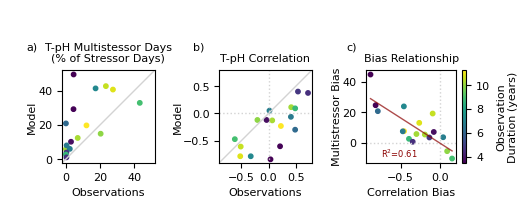

In [15]:
fig,ax=plt.subplots(1,3,figsize=(5.5,1.2),gridspec_kw={'width_ratios':[1,1,1],'wspace':.4})
m=ax[0].scatter(dfout_detrenddeseas.obspercTpH,dfout_detrenddeseas.modpercTpH,c=dfout_detrenddeseas.obs_N/365.25,s=10)
ax[0].set_title('T-pH Multistessor Days\n(% of Stressor Days)')
ax[0].set_xlabel('Observations')
ax[0].set_ylabel('Model',labelpad=1)
viz.squareax(ax[0])

# m=ax[1].scatter(dfout_detrenddeseas.obscov,dfout_detrenddeseas.modcov,c=dfout_detrenddeseas.obs_N/365.25,s=10)
# ax[1].set_title('Covariance (°C$\cdot$1)\nof T and pH in Detrended,\nDeseasonalized Series')
# ax[1].set_xlabel('Observations')
# ax[1].set_ylabel('Model')
# viz.squareax(ax[1])
# ax[1].axhline(0,color='lightgray',linestyle=':')
# ax[1].axvline(0,color='lightgray',linestyle=':')
# cb=fig.colorbar(m,cax=ax[2])
# cb.ax.set_ylabel('Observation\nDuration (years)')

m=ax[1].scatter(dfout_detrenddeseas.obscor,dfout_detrenddeseas.modcor,c=dfout_detrenddeseas.obs_N/365.25,s=10)
ax[1].set_title('T-pH Correlation')
ax[1].set_xlabel('Observations')
ax[1].set_ylabel('Model',labelpad=0)
viz.squareax(ax[1])
ax[1].axhline(0,color='lightgray',linestyle=':')
ax[1].axvline(0,color='lightgray',linestyle=':')

xx=dfout_detrenddeseas.modcor-dfout_detrenddeseas.obscor
yy=dfout_detrenddeseas.modpercTpH-dfout_detrenddeseas.obspercTpH
m=ax[2].scatter(xx,yy,c=dfout_detrenddeseas.obs_N/365.25,s=10)
#ax[2].set_title('Bias in Multistressor\nDays vs. Bias in\nCorrelation\n(Model-Observation)')
ax[2].set_ylabel('Multistressor Bias',labelpad=0)
ax[2].set_xlabel('Correlation Bias')
#viz.squareax(ax[2])
ax[2].axhline(0,color='lightgray',linestyle=':')
ax[2].axvline(0,color='lightgray',linestyle=':')
cb=fig.colorbar(m,ax=ax[2])
cb.ax.set_ylabel('Observation\nDuration (years)')
ll=cf.linreg(xx,yy)
xl=np.array([np.min(xx),np.max(xx)])
ax[2].plot(xl,ll.coef[0]+ll.coef[1]*xl,'-',color='darkred',alpha=.7)
ax[2].text(-.75,-10,f"R$^2$={ll.Rsq:.2f}",fontsize=6,color='darkred')
ax[2].set_title('Bias Relationship')

slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
ax[0].annotate('a)',xy=(.048, 1.32), xycoords='figure fraction')
ax[1].annotate('b)',xy=(.35, 1.32), xycoords='figure fraction')
ax[2].annotate('c)',xy=(.63, 1.32), xycoords='figure fraction')
#fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesPercentile_Rev.png',dpi=400,bbox_inches='tight')

In [16]:
ll=ax[0].xaxis.get_major_locator()

In [17]:
import matplotlib.ticker as mtick

In [18]:
isinstance(ll,mtick.AutoLocator)

False

In [19]:
print(slope, intercept, r_value, p_value, std_err)
print('p<.05?: p=',p_value)

-33.538949509825656 -0.4179137682420446 -0.7812514764977349 0.00021318789304000427 6.919076922909382
p<.05?: p= 0.00021318789304000427


In [20]:
ll

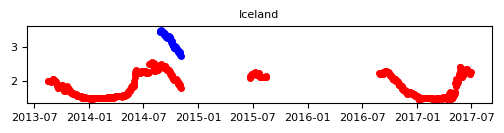

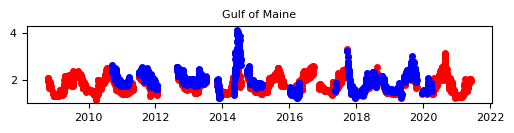

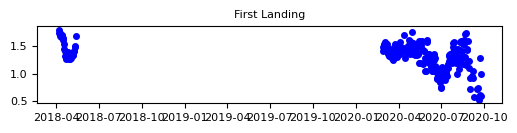

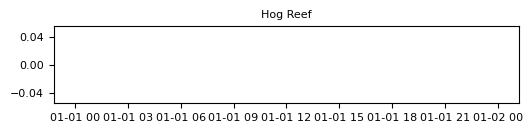

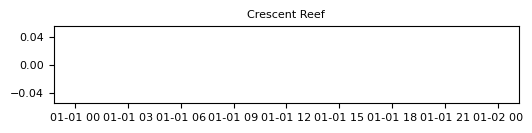

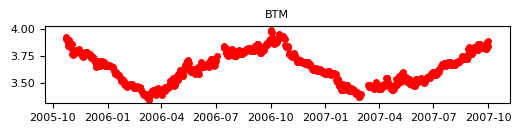

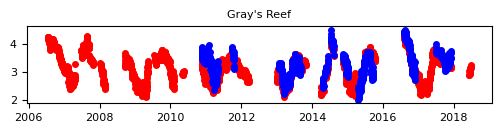

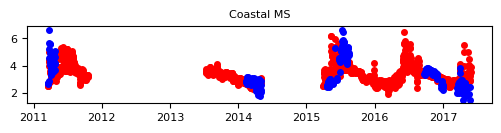

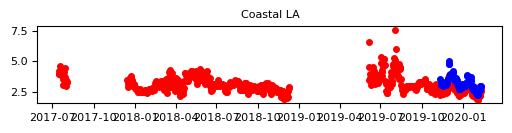

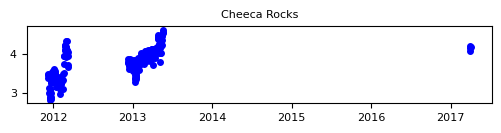

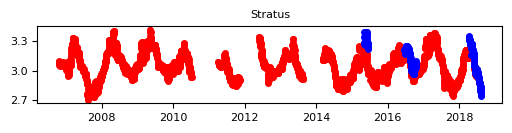

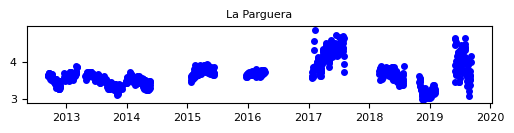

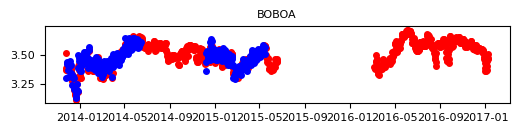

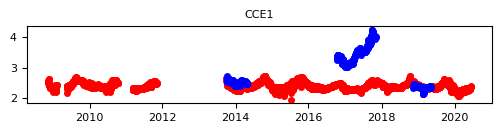

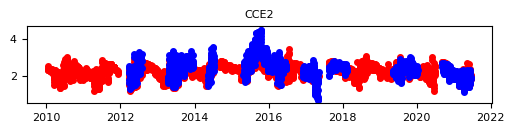

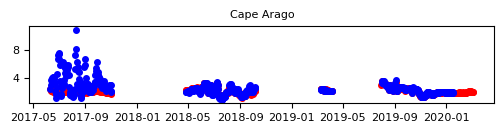

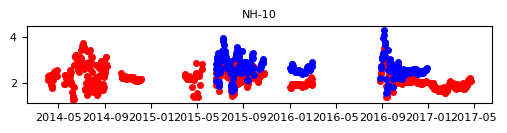

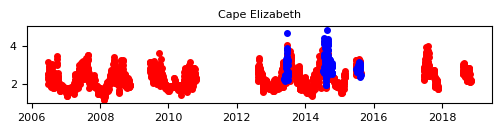

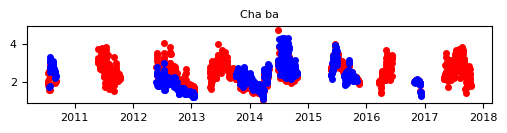

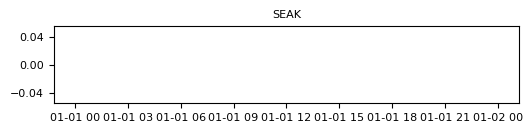

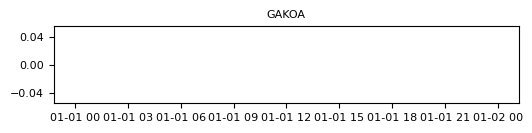

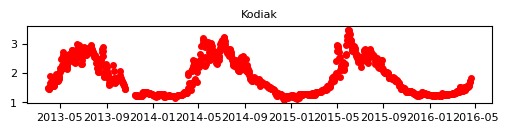

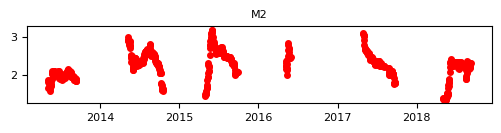

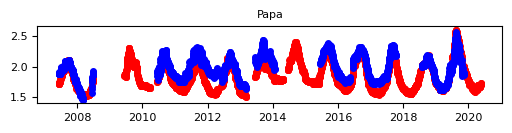

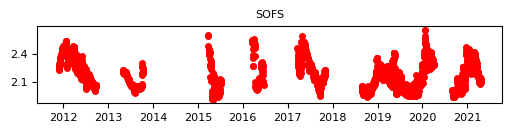

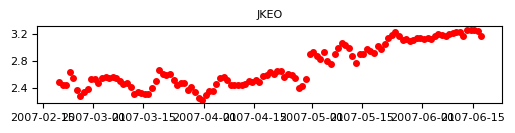

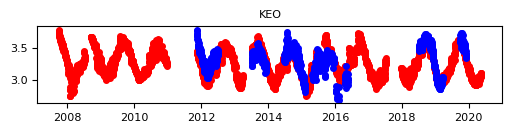

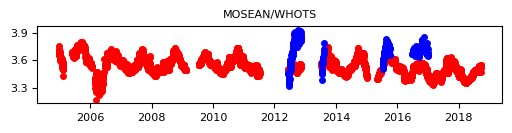

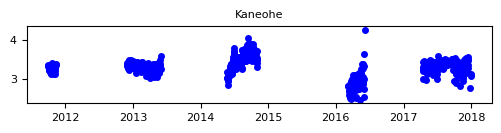

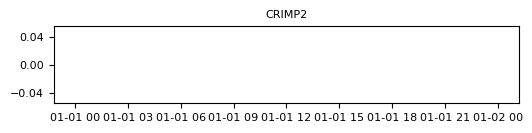

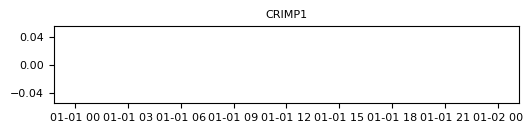

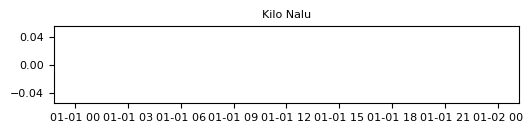

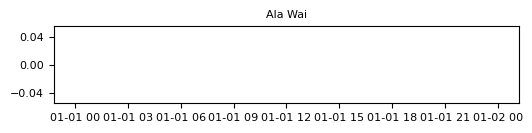

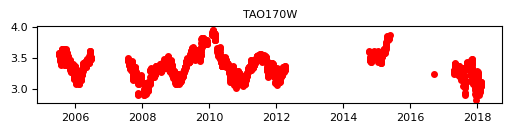

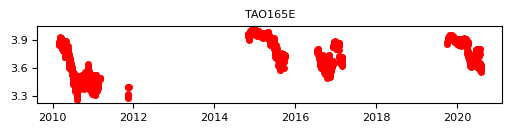

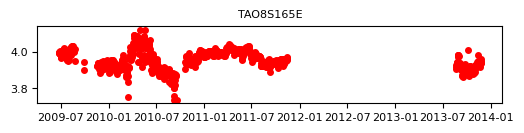

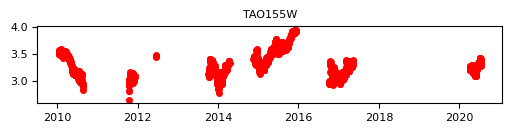

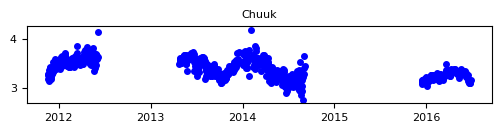

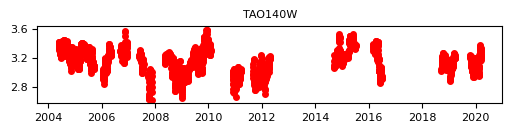

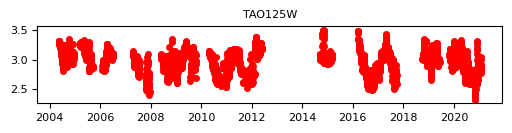

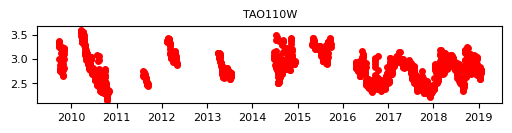

In [21]:
for dsid in dfInfoBuoy.datasetID.unique():
    docalc=True
    phCcomp=bc.loadMoorComp(dsid,'omega_a_0',freq='daily',path=cpath)
    phCcomp2=bc.loadMoorComp(dsid,'omega_a_P_0',freq='daily',path=cpath)
    fig,ax=plt.subplots(1,1,figsize=(6,1))
    ax.plot(phCcomp.obs_tdt,phCcomp.obs_val,'r.')
    ax.plot(phCcomp2.obs_tdt,phCcomp2.obs_val,'b.')
    ax.set_title(phCcomp.shortTitle)

In [22]:
# keep phosC column name but here contains omega_a_0. still looking for low values.
def percMult(t,ph,thresh=80):
    qt=np.nanpercentile(t,thresh)
    qph=np.nanpercentile(ph,100-thresh)
    it90=t>=qt
    iph90=ph<=qph
    ntot=np.sum(it90|iph90)
    print(qt,qph)
    return np.sum(it90&iph90)/ntot*100, ntot, qt-np.median(t), np.median(ph)-qph
res=[]
for dsid in dfInfoBuoy.datasetID.unique():
    senspH=False
    docalc=True
    tcomp=bc.loadMoorComp(dsid,'tos',freq='daily',path=cpath)
    phCcomp=bc.loadMoorComp(dsid,'omega_a_0',freq='daily',path=cpath)
    phCcomp2=bc.loadMoorComp(dsid,'omega_a_P_0',freq='daily',path=cpath)
    if len(phCcomp2.obs_val)>len(phCcomp.obs_val):
        phCcomp=phCcomp2
        senspH=True
    if np.sum(~pd.isnull(tcomp.obs_targetdeseas))>0:
        otvar=tcomp.obs_targetdeseas.astype(float)
    elif np.sum(~pd.isnull(tcomp.obs_targetdeseas_b))>0:
        otvar=tcomp.obs_targetdeseas_b.astype(float)
    else:
        docalc=False
    if np.sum(~pd.isnull(phCcomp.obs_targetdeseas))>0:
        ophvar=phCcomp.obs_targetdeseas.astype(float)
    elif np.sum(~pd.isnull(phCcomp.obs_targetdeseas_b))>0:
        ophvar=phCcomp.obs_targetdeseas_b.astype(float)
    else:
        docalc=False
    if docalc:
        obs_t=pd.DataFrame(np.array([tcomp.obs_tdt, otvar]).T,
                         columns=['dtUTC','tos'])
        obs_phC=pd.DataFrame(np.array([phCcomp.obs_tdt, ophvar]).T,
                           columns=['dtUTC','phosC'])
        obsdf=obs_t.merge(obs_phC,on='dtUTC')
        if len(obsdf)>365.25*minyears:
            if senspH:
                print('senspH version used:',dsid)
            mod_t=pd.DataFrame(np.array([tcomp.mod_tdt, tcomp.mod_targetdeseas.astype(float)]).T,
                             columns=['dtUTC','tos'])
            mod_phC=pd.DataFrame(np.array([phCcomp.mod_tdt, phCcomp.mod_targetdeseas.astype(float)]).T,
                               columns=['dtUTC','phosC'])
            moddf=mod_t.merge(mod_phC,on='dtUTC')
            obscov=np.cov(np.array(obsdf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
            obscor=np.corrcoef(np.array(obsdf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
            modcov=np.cov(np.array(moddf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
            modcor=np.corrcoef(np.array(moddf.loc[:,['tos','phosC']].values.astype(float)).T)[1,0]
            obspercTpH,obsN90,odt,odph=percMult(obsdf.tos,obsdf.phosC)
            modpercTpH,modN90,mdt,mdph=percMult(moddf.tos,moddf.phosC)
            obs_N=len(obsdf)
            res.append([dsid,obscov,modcov,obscor,modcor,obspercTpH,modpercTpH,obs_N,obsN90,
                        odt,odph,mdt,mdph])
dfout_detrenddeseas2=pd.DataFrame(res,columns=['datasetID','obscov','modcov','obscor','modcor','obspercTOm',
                                'modpercTOm','obs_N','obs_N90',
                                'obsdeltaT','obsdeltaOm','moddeltaT','moddeltaOm'])


11.496056813808934 1.7189615457748972
12.879882856737167 2.233948576763481
22.531250418116027 2.9303277928397238
22.412736021772858 3.380345965528556
24.783415003359657 3.0781237692359165
23.044155104082083 3.249213191261081
20.98497041343299 2.9755435605851934
22.074504927889684 3.0595995654192114
senspH version used: pmel_co2_moorings_ab03_dbac_935b
28.820203272169458 3.4354756940551954
27.92816207200557 3.8803503009358105
16.818660096067372 2.3423541969320407
17.747360062400375 2.39661989682059
15.535378269018077 2.116489213554193
17.629296714171044 2.300045898377292
12.355640149326256 1.992946721633365
12.954556231395847 1.74402920866421
12.345637705198753 2.004159549415943
13.36443385696771 1.8684969755898584
10.043711880075149 1.7694976909592508
9.81893057258002 1.8907563492906612
11.354518896289822 2.0940728432619036
10.573210142696684 2.089223508904759
23.06966753355459 3.212505366574578
21.072662107675427 3.022599962014306
25.51908896541108 3.4917138504144933
25.41951849704752

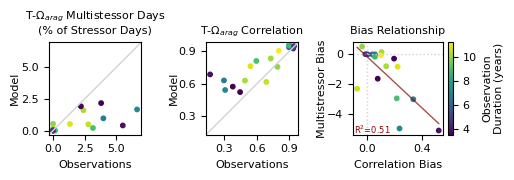

In [23]:
fig,ax=plt.subplots(1,3,figsize=(5.5,1.2),gridspec_kw={'width_ratios':[1,1,1],'wspace':.4})
m=ax[0].scatter(dfout_detrenddeseas2.obspercTOm,dfout_detrenddeseas2.modpercTOm,
                c=dfout_detrenddeseas2.obs_N/365.25,s=10)
ax[0].set_title('T-$\Omega_{arag}$ Multistessor Days\n(% of Stressor Days)')
ax[0].set_xlabel('Observations')
ax[0].set_ylabel('Model',labelpad=1)
viz.squareax(ax[0])

m=ax[1].scatter(dfout_detrenddeseas2.obscor,dfout_detrenddeseas2.modcor,
                c=dfout_detrenddeseas2.obs_N/365.25,s=10)
ax[1].set_title('T-$\Omega_{arag}$ Correlation')
ax[1].set_xlabel('Observations')
ax[1].set_ylabel('Model',labelpad=0)
viz.squareax(ax[1])
ax[1].axhline(0,color='lightgray',linestyle=':')
ax[1].axvline(0,color='lightgray',linestyle=':')

xx=dfout_detrenddeseas2.modcor-dfout_detrenddeseas2.obscor
yy=dfout_detrenddeseas2.modpercTOm-dfout_detrenddeseas2.obspercTOm
m=ax[2].scatter(xx,yy,c=dfout_detrenddeseas2.obs_N/365.25,s=10)
#ax[2].set_title('Bias in Multistressor\nDays vs. Bias in\nCorrelation\n(Model-Observation)')
ax[2].set_ylabel('Multistressor Bias',labelpad=0)
ax[2].set_xlabel('Correlation Bias')
#viz.squareax(ax[2])
ax[2].axhline(0,color='lightgray',linestyle=':')
ax[2].axvline(0,color='lightgray',linestyle=':')
cb=fig.colorbar(m,ax=ax[2])
cb.ax.set_ylabel('Observation\nDuration (years)')
ll=cf.linreg(xx,yy)
xl=np.array([np.min(xx),np.max(xx)])
ax[2].plot(xl,ll.coef[0]+ll.coef[1]*xl,'-',color='darkred',alpha=.7)
ax[2].set_title('Bias Relationship')
ax[2].text(.015, .01,f"R$^2$={ll.Rsq:.2f}",fontsize=6,color='darkred',transform=ax[2].transAxes)

slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
#ax[0].annotate('a)',xy=(.048, 1.32), xycoords='figure fraction')
#ax[1].annotate('b)',xy=(.35, 1.32), xycoords='figure fraction')
#ax[2].annotate('c)',xy=(.63, 1.32), xycoords='figure fraction')
#fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesPercentileTOm.png',dpi=400,bbox_inches='tight')

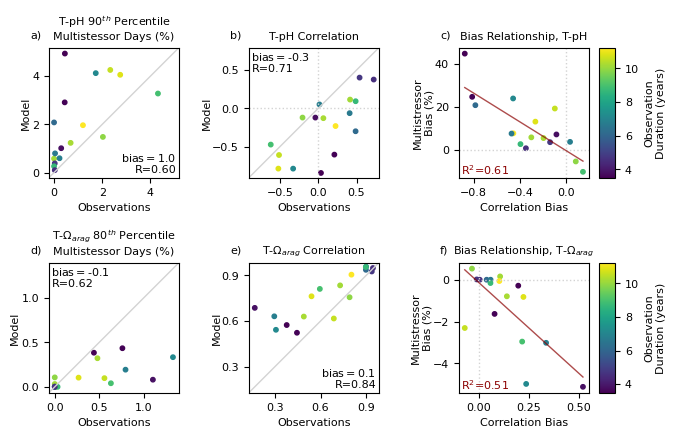

In [24]:
fw=6.5
fh=4
fig=plt.figure(figsize=(fw,fh))
ax=[]
x1=.5/fw
x2=2.5/fw
x3=4.6/fw
x4=6/fw
xw=1.3/fw
yw=1.3/fh
y0=.25/fh
y1=.6
ya0=y0+yw+.3/fh # letter position
ya1=y1+yw+.3/fh # letter position
dax=.2/fw
ax.append(fig.add_axes((x1, y1, xw, yw)))
ax.append(fig.add_axes((x2, y1, xw, yw)))
ax.append(fig.add_axes((x3, y1, xw, yw)))
ax.append(fig.add_axes((x1, y0, xw, yw)))
ax.append(fig.add_axes((x2, y0, xw, yw)))
ax.append(fig.add_axes((x3, y0, xw, yw)))
cbax1=fig.add_axes((x4, y1, xw/8, yw))
cbax2=fig.add_axes((x4, y0, xw/8, yw))
#fig,ax=plt.subplots(2,3,figsize=(5.5,2.7),gridspec_kw={'width_ratios':[1,1,.6],'wspace':.2,'hspace':1.2})
#ax=ax.flatten()
m=ax[0].scatter(dfout_detrenddeseas.obspercTpH*.1,dfout_detrenddeseas.modpercTpH*.1,c=dfout_detrenddeseas.obs_N/365.25,s=10)
ax[0].set_title('T-pH 90$^{th}$ Percentile\nMultistessor Days (%)')
ax[0].set_xlabel('Observations')
ax[0].set_ylabel('Model',labelpad=1)
viz.squareax(ax[0])
R=np.corrcoef(dfout_detrenddeseas.obspercTpH*.1,dfout_detrenddeseas.modpercTpH*.1)[0,1]
bb=np.mean(dfout_detrenddeseas.modpercTpH*.1-dfout_detrenddeseas.obspercTpH*.1)
ax[0].text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
                             transform=ax[0].transAxes)

m=ax[1].scatter(dfout_detrenddeseas.obscor,dfout_detrenddeseas.modcor,c=dfout_detrenddeseas.obs_N/365.25,s=10)
ax[1].set_title('T-pH Correlation')
ax[1].set_xlabel('Observations')
ax[1].set_ylabel('Model',labelpad=0)
viz.squareax(ax[1])
ax[1].axhline(0,color='lightgray',linestyle=':')
ax[1].axvline(0,color='lightgray',linestyle=':')
R=np.corrcoef(dfout_detrenddeseas.obscor,dfout_detrenddeseas.modcor)[0,1]
bb=np.mean(dfout_detrenddeseas.modcor-dfout_detrenddeseas.obscor)
ax[1].text(.02, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='left', va='top',
                             transform=ax[1].transAxes)

xx=dfout_detrenddeseas.modcor-dfout_detrenddeseas.obscor
yy=dfout_detrenddeseas.modpercTpH-dfout_detrenddeseas.obspercTpH
m=ax[2].scatter(xx,yy,c=dfout_detrenddeseas.obs_N/365.25,s=10)
#ax[2].set_title('Bias in Multistressor\nDays vs. Bias in\nCorrelation\n(Model-Observation)')
ax[2].set_ylabel('Multistressor\nBias (%)',labelpad=0)
ax[2].set_xlabel('Correlation Bias')
#viz.squareax(ax[2])
ax[2].axhline(0,color='lightgray',linestyle=':')
ax[2].axvline(0,color='lightgray',linestyle=':')
cb=fig.colorbar(m,cax=cbax1,label='Observation\nDuration (years)')
#cbax1.set_ylabel()
ll=cf.linreg(xx,yy)
xl=np.array([np.min(xx),np.max(xx)])
ax[2].plot(xl,ll.coef[0]+ll.coef[1]*xl,'-',color='darkred',alpha=.7)
#ax[2].text(-.75,-10,f"R$^2$={ll.Rsq:.2f}",fontsize=6,color='darkred')
ax[2].text(.015, .01, f"R$^2$={ll.Rsq:.2f}", ha='left', va='bottom', color='darkred',
                             transform=ax[2].transAxes)
ax[2].set_title('Bias Relationship, T-pH')

slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
ax[0].annotate('a)',xy=(x1-dax, ya1), xycoords='figure fraction')
ax[1].annotate('b)',xy=(x2-dax, ya1), xycoords='figure fraction')
ax[2].annotate('c)',xy=(x3-dax, ya1), xycoords='figure fraction')


m=ax[3].scatter(dfout_detrenddeseas2.obspercTOm*.2,dfout_detrenddeseas2.modpercTOm*.2,
                c=dfout_detrenddeseas2.obs_N/365.25,s=10)
ax[3].set_title('T-$\Omega_{arag}$ 80$^{th}$ Percentile\nMultistessor Days (%)')
ax[3].set_xlabel('Observations')
ax[3].set_ylabel('Model',labelpad=1)
viz.squareax(ax[3])
R=np.corrcoef(dfout_detrenddeseas2.obspercTOm*.1,dfout_detrenddeseas2.modpercTOm*.1)[0,1]
bb=np.mean(dfout_detrenddeseas2.modpercTOm*.1-dfout_detrenddeseas2.obspercTOm*.1)
ax[3].text(.02, .98, f"bias$=${bb:.1f}\nR={R:.2f}", ha='left', va='top',
                             transform=ax[3].transAxes)

m=ax[4].scatter(dfout_detrenddeseas2.obscor,dfout_detrenddeseas2.modcor,
                c=dfout_detrenddeseas2.obs_N/365.25,s=10)
ax[4].set_title('T-$\Omega_{arag}$ Correlation')
ax[4].set_xlabel('Observations')
ax[4].set_ylabel('Model',labelpad=0)
viz.squareax(ax[4])
ax[4].axhline(0,color='lightgray',linestyle=':')
ax[4].axvline(0,color='lightgray',linestyle=':')
R=np.corrcoef(dfout_detrenddeseas2.obscor,dfout_detrenddeseas2.modcor)[0,1]
bb=np.mean(dfout_detrenddeseas2.modcor-dfout_detrenddeseas2.obscor)
ax[4].text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
                             transform=ax[4].transAxes)

xx=dfout_detrenddeseas2.modcor-dfout_detrenddeseas2.obscor
yy=dfout_detrenddeseas2.modpercTOm-dfout_detrenddeseas2.obspercTOm
m=ax[5].scatter(xx,yy,c=dfout_detrenddeseas2.obs_N/365.25,s=10)
#ax[5].set_title('Bias in Multistressor\nDays vs. Bias in\nCorrelation\n(Model-Observation)')
ax[5].set_ylabel('Multistressor\nBias (%)',labelpad=0)
ax[5].set_xlabel('Correlation Bias')
#viz.squareax(ax[2])
ax[5].axhline(0,color='lightgray',linestyle=':')
ax[5].axvline(0,color='lightgray',linestyle=':')
cb=fig.colorbar(m,cax=cbax2,label='Observation\nDuration (years)')
#cbax2.set_ylabel('Observation\nDuration (years)')
ll=cf.linreg(xx,yy)
xl=np.array([np.min(xx),np.max(xx)])
ax[5].plot(xl,ll.coef[0]+ll.coef[1]*xl,'-',color='darkred',alpha=.7)
ax[5].set_title('Bias Relationship, T-$\Omega_{arag}$')
ax[5].text(.015, .01, f"R$^2$={ll.Rsq:.2f}", ha='left', va='bottom', color='darkred',
                             transform=ax[5].transAxes)
#ax[2].text(-.75,-10,f"R$^2$={ll.Rsq:.2f}",fontsize=6,color='darkred')

slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
ax[3].annotate('d)',xy=(x1-dax, ya0), xycoords='figure fraction')
ax[4].annotate('e)',xy=(x2-dax, ya0), xycoords='figure fraction')
ax[5].annotate('f)',xy=(x3-dax, ya0), xycoords='figure fraction')

fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesPercentile2Row_Rev.pdf',dpi=400,bbox_inches='tight')
fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesPercentile2Row_Rev.tif',dpi=400,bbox_inches='tight')

In [25]:
# stations, ordered by T-pH days
xdf=dfout_detrenddeseas.loc[(dfout_detrenddeseas.modpercTpH>0)|(dfout_detrenddeseas.obspercTpH>0),
                        ['datasetID','modpercTpH','obspercTpH']]
xdf['shortTitle']=[dfInfoBuoy.loc[dfInfoBuoy.datasetID==idd,['shortTitle']].values[0][0] for idd in xdf.datasetID]
xdf['Mean']=[.5*(a+b) for a,b in zip(xdf.modpercTpH,xdf.obspercTpH)]
xdf.loc[:,['shortTitle','modpercTpH','obspercTpH','Mean']].sort_values('Mean', ascending=False)

,shortTitle,modpercTpH,obspercTpH,Mean
5,CCE1,32.777567,43.107221,37.942394
12,MOSEAN/WHOTS,40.553550,27.447833,34.000692
11,KEO,42.554923,23.322684,32.938803
1,Gray's Reef,41.233374,17.303371,29.268372
4,La Parguera,49.360614,4.489796,26.925205
3,Stratus,14.772355,20.265781,17.519068
2,Coastal MS,29.108327,4.417671,16.762999
9,Papa,19.631273,11.989101,15.810187
13,TAO170W,20.785936,0.000000,10.392968
0,Gulf of Maine,12.307692,6.876791,9.592242


In [26]:
# stations, ordered by T-Om days
xdf=dfout_detrenddeseas2.loc[(dfout_detrenddeseas2.modpercTOm>0)|(dfout_detrenddeseas2.obspercTOm>0),
                        ['datasetID','modpercTOm','obspercTOm']]
xdf['shortTitle']=[dfInfoBuoy.loc[dfInfoBuoy.datasetID==idd,['shortTitle']].values[0][0] for idd in xdf.datasetID]
xdf['Mean']=[.5*(a+b) for a,b in zip(xdf.modpercTOm,xdf.obspercTOm)]
xdf.loc[:,['shortTitle','modpercTOm','obspercTOm','Mean']].sort_values('Mean', ascending=False)

,shortTitle,modpercTOm,obspercTOm,Mean
1,Gray's Reef,1.668359,6.653019,4.160689
2,Coastal MS,2.172328,3.807615,2.989972
8,Cha ba,0.401146,5.523810,2.962478
7,Cape Elizabeth,0.965279,3.983229,2.474254
4,La Parguera,1.919721,2.204409,2.062065
0,Gulf of Maine,1.609395,2.402196,2.005796
5,CCE1,0.200172,3.159558,1.679865
11,KEO,0.487525,2.796272,1.641898
12,MOSEAN/WHOTS,0.516351,1.340140,0.928246
3,Stratus,0.530770,0.000000,0.265385


### fixed baselines: NOAA coral bleaching temperature threshold (satellite product for obs and corresponding MMM estimate for model) and omega_arag<3

In [27]:
dfInfoBuoy.keys()

Index(['datasetID', 'title', 'minTime', 'maxTime', 'Lat', 'Lon', 'tabfile',
       'jj', 'ii', 'Lat1x1', 'Lon1x1', 'jj288', 'ii288', 'modBathy',
       'shortTitle', 'agessc_100m', 'agessc_50m', 'agessc_0m', 'age_200',
       'tos', 'sos', 'intpp', 'chlos', 'phos', 'fgco2', 'talkos', 'no3os',
       'MLD_003'],
      dtype='object')

In [28]:
# store thresholds: 
df_T_thresh=dfInfoBuoy.loc[:,['datasetID','shortTitle','Lat', 'Lon','jj', 'ii',]].copy(deep=True)

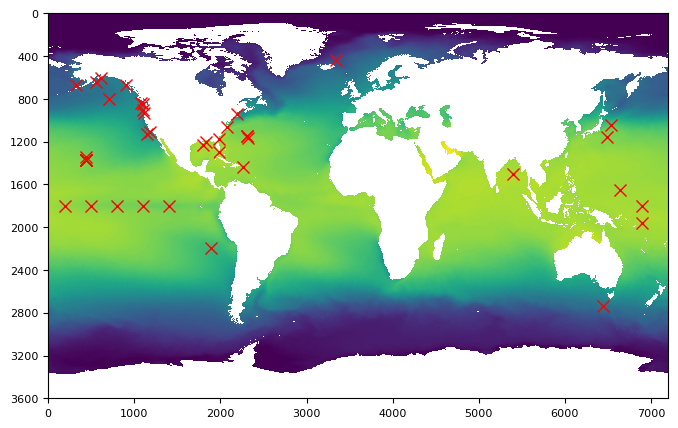

In [29]:
# obs threshold: MMM+1, use NOAA satellite climatology
ds3=xr.open_dataset('/work/ebo/calcs/extremes/MMM_NOAA/ct5km_climatology_v3.1.nc')
clo,cla=np.meshgrid(ds3.lon,ds3.lat)
out=list()
df_T_thresh['T_MMM_obs']=np.nan
for ind, row in df_T_thresh.iterrows():
    cjj,cii=cf.nearest_point(row['Lat'],row['Lon'],cla,clo,thresh=2*5*np.sqrt(2)/2)
    #print(row.Lat,row.Lon,cjj,cii)
    MMM=ds3['sst_clim_mmm'].values[0,cjj,cii]
    if np.isnan(MMM):
        MMM=np.nanmean(ds3['sst_clim_mmm'].values[0,cjj-2:cjj+3,cii-2:cii+3]) # try larger area
    df_T_thresh.loc[df_T_thresh.datasetID==row['datasetID'],['T_MMM_obs']]=MMM
    out.append([cjj,cii,MMM])

fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.pcolormesh(ds3['sst_clim_mmm'].values[0,:,:])
ax.invert_yaxis()
for row in out:
    ax.plot(row[1],row[0],'rx')
ds3.close()

In [30]:
# Model T threshold: MMM+1, use model climatology
dsm=xr.open_dataset('/work/ebo/calcs/extremes/MMM_NOAA/MMM.presentday.1975_2022.19880414.nc')
out2=list()
df_T_thresh['T_MMM_mod']=np.nan
for ind, row in df_T_thresh.iterrows():
    MMM=dsm['MMM'].values[row['jj'],row['ii']]
    df_T_thresh.loc[df_T_thresh.datasetID==row['datasetID'],['T_MMM_mod']]=MMM
    out2.append(MMM)
dsm.close()

In [31]:
df_T_thresh

,datasetID,shortTitle,Lat,Lon,jj,ii,T_MMM_obs,T_MMM_mod
0,pmel_co2_moorings_ba50_a09b_5565,Iceland,68.000,-12.6700,158,347,6.270000,6.558500
1,pmel_co2_moorings_c2e7_ecb9_4565,Gulf of Maine,43.023,-70.5420,133,289,17.039999,18.934269
2,pmel_co2_moorings_c64b_e2bb_dc32,First Landing,36.998,-76.0880,127,283,24.959999,28.286383
3,pmel_co2_moorings_4e4c_1834_1204,Hog Reef,32.460,-64.8300,122,295,27.260000,26.976718
4,pmel_co2_moorings_e1ef_470f_1fee,Crescent Reef,32.400,-64.7900,122,295,27.289999,26.976718
5,pmel_co2_moorings_939b_fc25_57be,BTM,31.500,-64.2000,121,295,27.599998,27.339582
6,pmel_co2_moorings_ab27_2faf_3aa1,Gray's Reef,31.400,-80.8700,121,279,28.340000,28.129665
7,pmel_co2_moorings_cf08_f32f_712a,Coastal MS,30.000,-88.6000,120,271,29.289999,30.517232
8,pmel_co2_moorings_0af7_8b89_77bd,Coastal LA,28.520,-90.2878,118,269,29.549999,30.000552
9,pmel_co2_moorings_045c_c8bc_b1c6,Cheeca Rocks,24.910,-80.6240,114,279,29.650000,29.516738


In [32]:
def stressorcount(x,y,threshx,threshy,facx=1,facy=1):
    # set fac to -1 if stressor criteria is below threshold instead of above threshold
    ix=facx*x>facx*threshx
    iy=facy*y>facy*threshy
    ireal=~np.isnan(x)&~np.isnan(y)
    return np.sum(ix),np.sum(iy),np.sum(ix&iy),np.sum(ix|iy),np.sum(ireal)

### separate T thresholds for mod and obs, with model detrended to mean date of obs

In [33]:
# Using T=MMM+1 and omega_arag=3 thresholds, calculate stressor and multiple stressor estimates:

thresh_om=3
res=[]
for dsid in dfInfoBuoy.datasetID.unique():
    senspH=False
    #print(dsid)
    tcomp=bc.loadMoorComp(dsid,'tos',freq='daily',path=cpath)
    phCcomp=bc.loadMoorComp(dsid,'omega_a_0',freq='daily',path=cpath)
    phCcomp2=bc.loadMoorComp(dsid,'omega_a_P_0',freq='daily',path=cpath)
    if len(phCcomp2.obs_val)>len(phCcomp.obs_val):
        phCcomp=phCcomp2
        senspH=True
    obs_t=pd.DataFrame(np.array([tcomp.obs_tdt, tcomp.obs_val.astype(float)]).T,
                     columns=['dtUTC','tos'])
    obs_phC=pd.DataFrame(np.array([phCcomp.obs_tdt, phCcomp.obs_val.astype(float)]).T,
                       columns=['dtUTC','om_arag'])
    obsdf=obs_t.merge(obs_phC,on='dtUTC')
    if len(obsdf)>365.25*minyears:
        if senspH:
            print('senspH version used:',dsid)
        thresh_T_obs=np.squeeze(df_T_thresh.loc[df_T_thresh.datasetID==dsid,['T_MMM_obs']].values[0])+1
        thresh_T_mod=np.squeeze(df_T_thresh.loc[df_T_thresh.datasetID==dsid,['T_MMM_mod']].values[0])+1
        mod_t=pd.DataFrame(np.array([tcomp.mod_tdt, tcomp.mod_target.astype(float)]).T,
                         columns=['dtUTC','tos'])
        mod_phC=pd.DataFrame(np.array([phCcomp.mod_tdt, phCcomp.mod_target.astype(float)]).T,
                           columns=['dtUTC','om_arag'])
        moddf=mod_t.merge(mod_phC,on='dtUTC')
        Nt_obs,Nom_obs,Nmix_obs,Nstress_obs,Ntot_obs=stressorcount(obsdf.tos.values.astype(float),obsdf.om_arag.values.astype(float),
                                                       thresh_T_obs,thresh_om,1,-1)
        Nt_mod,Nom_mod,Nmix_mod,Nstress_mod,Ntot_mod=stressorcount(moddf.tos.values.astype(float),moddf.om_arag.values.astype(float),
                                                       thresh_T_mod,thresh_om,1,-1)
        res.append([dsid,Nt_obs,Nom_obs,Nmix_obs,Nstress_obs,Ntot_obs,Nt_mod,Nom_mod,Nmix_mod,Nstress_mod,Ntot_mod])
dfoutStat2=pd.DataFrame(res,columns=['datasetID','Nt_obs','Nom_obs','Nmix_obs','Nstress_obs','Ntot_obs',
                                     'Nt_mod','Nom_mod','Nmix_mod','Nstress_mod','Ntot_mod'])
dfoutStat2['fT_obs']=dfoutStat2['Nt_obs']/dfoutStat2['Ntot_obs']
dfoutStat2['fom_obs']=dfoutStat2['Nom_obs']/dfoutStat2['Ntot_obs']
dfoutStat2['fmix_obs']=dfoutStat2['Nmix_obs']/dfoutStat2['Ntot_obs']
dfoutStat2['fT_mod']=dfoutStat2['Nt_mod']/dfoutStat2['Ntot_mod']
dfoutStat2['fom_mod']=dfoutStat2['Nom_mod']/dfoutStat2['Ntot_mod']
dfoutStat2['fmix_mod']=dfoutStat2['Nmix_mod']/dfoutStat2['Ntot_mod']
dfoutStat2['rmix_obs']=dfoutStat2['Nmix_obs']/dfoutStat2['Nstress_obs']
dfoutStat2['rmix_mod']=dfoutStat2['Nmix_mod']/dfoutStat2['Nstress_mod']

senspH version used: pmel_co2_moorings_ab03_dbac_935b


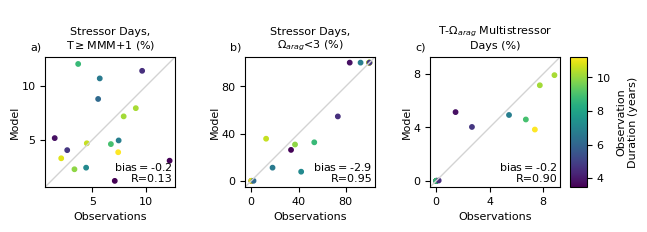

In [34]:
df=dfoutStat2

fig=plt.figure(figsize=(fw,fh/2))
ax=[]
x3=4.35/fw
x4=5.75/fw
ax.append(fig.add_axes((x1, y0, xw, yw*2)))
ax.append(fig.add_axes((x2, y0, xw, yw*2)))
ax.append(fig.add_axes((x3, y0, xw, yw*2)))
cbax1=fig.add_axes((x4, y0, xw/8, yw*2))

#fig,ax=plt.subplots(1,4,figsize=(6.5,1.4),gridspec_kw={'width_ratios':[1,1,1,.05],'wspace':.1})
m=ax[0].scatter(df['fT_obs']*100,df['fT_mod']*100,c=df['Ntot_obs']/365.25,s=10)
ax[0].set_title('Stressor Days,\nT$\geq$MMM+1 (%)')
R=np.corrcoef(df['fT_obs']*100,df['fT_mod']*100)[0,1]
bb=np.mean(df['fT_mod']*100-df['fT_obs']*100)
ax[0].text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
                             transform=ax[0].transAxes)
ax[1].scatter(df['fom_obs']*100,df['fom_mod']*100,c=df['Ntot_obs']/365.25,s=10)
ax[1].set_title('Stressor Days,\n$\Omega_{arag}$<3 (%)')
R=np.corrcoef(df['fom_obs']*100,df['fom_mod']*100)[1,0]
bb=np.mean(df['fom_mod']*100-df['fom_obs']*100)
ax[1].text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
                             transform=ax[1].transAxes)
ax[2].scatter(df['fmix_obs']*100,df['fmix_mod']*100,c=df['Ntot_obs']/365.25,s=10)
ax[2].set_title('T-$\Omega_{arag}$ Multistressor\nDays (%)')
R=np.corrcoef(df['fmix_obs']*100,df['fmix_mod']*100)[1,0]
bb=np.mean(df['fmix_mod']*100-df['fmix_obs']*100)
ax[2].text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
                             transform=ax[2].transAxes)
cb=fig.colorbar(m,cax=cbax1,label='Observation\nDuration (years)')
for iax in ax[:3]:
    iax.set_xlabel('Observations')
    iax.set_ylabel('Model',labelpad=1)
    viz.squareax(iax)

# ax[0].annotate('a)',xy=(.06, 1.25), xycoords='figure fraction')
# ax[1].annotate('b)',xy=(.34, 1.25), xycoords='figure fraction')
# ax[2].annotate('c)',xy=(.6, 1.25), xycoords='figure fraction')
ax[0].annotate('a)',xy=(x1-dax, y0+yw*2.6), xycoords='figure fraction')
ax[1].annotate('b)',xy=(x2-dax, y0+yw*2.6), xycoords='figure fraction')
ax[2].annotate('c)',xy=(x3-dax, y0+yw*2.6), xycoords='figure fraction')
fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesTOm_Rev.pdf',dpi=400,bbox_inches='tight')
fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesTOm_Rev.tif',dpi=400,bbox_inches='tight')

In [35]:
# stations, ordered by T-Om days
xdf=df.loc[:,['datasetID','fmix_mod','fmix_obs']]
xdf['shortTitle']=[dfInfoBuoy.loc[dfInfoBuoy.datasetID==idd,['shortTitle']].values[0][0] for idd in xdf.datasetID]
xdf['Mean']=[.5*(a+b) for a,b in zip(df.fmix_mod,xdf.fmix_obs)]
xdf.loc[:,['shortTitle','fmix_mod','fmix_obs','Mean']].sort_values('Mean', ascending=False)

,shortTitle,fmix_mod,fmix_obs,Mean
0,Gulf of Maine,0.079167,0.088543,0.083855
6,CCE2,0.071575,0.077586,0.074581
5,CCE1,0.045947,0.067116,0.056532
9,Papa,0.038413,0.073866,0.056140
7,Cape Elizabeth,0.049315,0.054501,0.051908
10,SOFS,0.040354,0.026729,0.033541
8,Cha ba,0.051484,0.014451,0.032967
16,TAO110W,0.000228,0.001812,0.001020
4,La Parguera,0.000000,0.000000,0.000000
1,Gray's Reef,0.000000,0.000000,0.000000


Text(0.6384615384615384, 0.9075000000000001, 'c)')

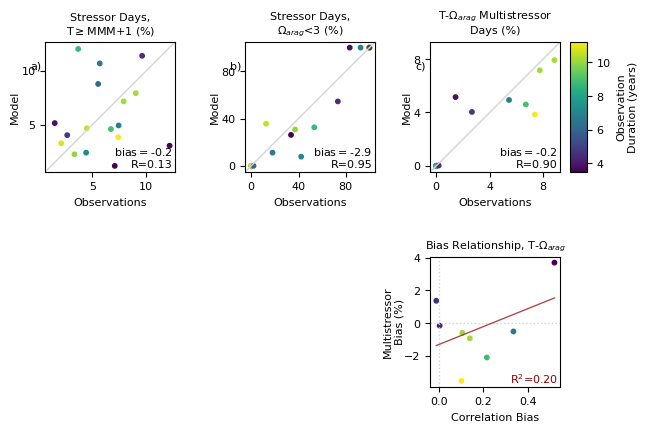

In [36]:
dftemp=df.merge(dfout_detrenddeseas2,on='datasetID')
dftemp2=dftemp.loc[(dftemp.fmix_mod>0)&(dftemp.fmix_obs>0)]
df=dfoutStat2

fig=plt.figure(figsize=(fw,fh))
ax=[]
x3=4.35/fw
x4=5.75/fw
ax.append(fig.add_axes((x1, y1, xw, yw)))
ax.append(fig.add_axes((x2, y1, xw, yw)))
ax.append(fig.add_axes((x3, y1, xw, yw)))
cbax1=fig.add_axes((x4, y1, xw/8, yw))
ax.append(fig.add_axes((x3,y0,xw,yw)))

#fig,ax=plt.subplots(1,4,figsize=(6.5,1.4),gridspec_kw={'width_ratios':[1,1,1,.05],'wspace':.1})
m=ax[0].scatter(df['fT_obs']*100,df['fT_mod']*100,c=df['Ntot_obs']/365.25,s=10)
ax[0].set_title('Stressor Days,\nT$\geq$MMM+1 (%)')
R=np.corrcoef(df['fT_obs']*100,df['fT_mod']*100)[0,1]
bb=np.mean(df['fT_mod']*100-df['fT_obs']*100)
ax[0].text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
                             transform=ax[0].transAxes)
ax[1].scatter(df['fom_obs']*100,df['fom_mod']*100,c=df['Ntot_obs']/365.25,s=10)
ax[1].set_title('Stressor Days,\n$\Omega_{arag}$<3 (%)')
R=np.corrcoef(df['fom_obs']*100,df['fom_mod']*100)[1,0]
bb=np.mean(df['fom_mod']*100-df['fom_obs']*100)
ax[1].text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
                             transform=ax[1].transAxes)
ax[2].scatter(df['fmix_obs']*100,df['fmix_mod']*100,c=df['Ntot_obs']/365.25,s=10)
ax[2].set_title('T-$\Omega_{arag}$ Multistressor\nDays (%)')
R=np.corrcoef(df['fmix_obs']*100,df['fmix_mod']*100)[1,0]
bb=np.mean(df['fmix_mod']*100-df['fmix_obs']*100)
ax[2].text(.98, .02, f"bias$=${bb:.1f}\nR={R:.2f}", ha='right', va='bottom',
                             transform=ax[2].transAxes)
cb=fig.colorbar(m,cax=cbax1,label='Observation\nDuration (years)')
for iax in ax[:3]:
    iax.set_xlabel('Observations')
    iax.set_ylabel('Model',labelpad=1)
    viz.squareax(iax)
    
xx=dftemp2.modcor-dftemp2.obscor
yy=(dftemp2.fmix_mod-dftemp2.fmix_obs)*100
m=ax[3].scatter(xx,yy,c=dftemp2.obs_N/365.25,s=10)
ax[3].set_ylabel('Multistressor\nBias (%)',labelpad=0)
ax[3].set_xlabel('Correlation Bias')
ax[3].axhline(0,color='lightgray',linestyle=':')
ax[3].axvline(0,color='lightgray',linestyle=':')
#cb=fig.colorbar(m,cax=cbax2,label='Observation\nDuration (years)')
ll=cf.linreg(xx,yy)
xl=np.array([np.min(xx),np.max(xx)])
ax[3].plot(xl,ll.coef[0]+ll.coef[1]*xl,'-',color='darkred',alpha=.7)
ax[3].set_title('Bias Relationship, T-$\Omega_{arag}$')
ax[3].text(.98, .01, f"R$^2$={ll.Rsq:.2f}", ha='right', va='bottom', color='darkred',
                             transform=ax[3].transAxes)

ax[0].annotate('a)',xy=(x1-dax, y0+yw*2.6), xycoords='figure fraction')
ax[1].annotate('b)',xy=(x2-dax, y0+yw*2.6), xycoords='figure fraction')
ax[2].annotate('c)',xy=(x3-dax, y0+yw*2.6), xycoords='figure fraction')
#fig.savefig('/home/ebo/OAPMSE/paperFigs/modObsExtremesTOmCor.png',dpi=400,bbox_inches='tight')